In [1]:
import sys
sys.path.append("../../XLEMOO")

In [2]:
from XLEMOO.LEMOO import EAParams, MLParams, LEMParams, LEMOO, PastGeneration
from XLEMOO.fitness_indicators import asf_wrapper
from XLEMOO.selection import SelectNBest
from XLEMOO.plotting import show_rules
from XLEMOO.ruleset_interpreter import extract_skoped_rules
from desdeo_emo.recombination import SBX_xover, BP_mutation
from desdeo_tools.scalarization.ASF import PointMethodASF
from desdeo_problem.testproblems import vehicle_crashworthiness

import matplotlib.pyplot as plt
import numpy as np
from imodels import SkopeRulesClassifier

## Initialize the problem

In [3]:
n_objectives = 3
n_variables = 5

problem = vehicle_crashworthiness()

## Initialize an XLEMOO method

In [35]:
ideal = np.array([1600.0, 6.0, 0.038])
nadir = np.array([1700.0, 12.0, 0.2])
ref_point = np.array([1650.0, 7.0, 0.05])  # the reference point
# ref_point = np.array([1690.0, 6.5, 0.039])  # the reference point

# define the achievement scalarizing function as the fitness function
ref_asf = asf_wrapper(PointMethodASF(ideal=ideal, nadir=nadir), {"reference_point": ref_point})
fitness_fun = ref_asf

lem_params = LEMParams(
    use_darwin=True,
    use_ml=True,
    fitness_indicator=fitness_fun,
    ml_probe = 1,
    ml_threshold = None,
    darwin_probe = None,
    darwin_threshold = None,
    total_iterations=15,
)

ea_params = EAParams(
    population_size=50,
    cross_over_op=SBX_xover(),
    mutation_op=BP_mutation(problem.get_variable_lower_bounds(), problem.get_variable_upper_bounds()),
    selection_op=SelectNBest(None, 50),  # keep population size constant
    population_init_design="LHSDesign",
    iterations_per_cycle=19,
)

ml = SkopeRulesClassifier(precision_min=0.1, n_estimators=30, max_features=None, max_depth=None, bootstrap=True, bootstrap_features=True, random_state=1)
ml_params = MLParams(
    H_split=0.25,
    L_split=0.25,
    ml_model=ml,
    instantation_factor=10,
    generation_lookback=0,
    ancestral_recall=0,
    unique_only=True,
    iterations_per_cycle=1,
)

lemoo = LEMOO(problem, lem_params, ea_params, ml_params)

## Run the XLEMOO method

In [36]:
lemoo.run_iterations()

h_gorup shape: (110, 5)
l_gorup shape: (110, 5)
.
h_gorup shape: (189, 5)
l_gorup shape: (189, 5)
.
h_gorup shape: (250, 5)
l_gorup shape: (250, 5)
.
h_gorup shape: (314, 5)
l_gorup shape: (314, 5)
.
h_gorup shape: (382, 5)
l_gorup shape: (382, 5)
.
h_gorup shape: (449, 5)
l_gorup shape: (449, 5)
.
h_gorup shape: (521, 5)
l_gorup shape: (521, 5)
.
h_gorup shape: (589, 5)
l_gorup shape: (589, 5)
.
h_gorup shape: (659, 5)
l_gorup shape: (659, 5)
.
h_gorup shape: (726, 5)
l_gorup shape: (726, 5)
.
h_gorup shape: (796, 5)
l_gorup shape: (796, 5)
.
h_gorup shape: (862, 5)
l_gorup shape: (862, 5)
.
h_gorup shape: (926, 5)
l_gorup shape: (926, 5)
.
h_gorup shape: (1002, 5)
l_gorup shape: (1002, 5)
.
h_gorup shape: (1063, 5)
l_gorup shape: (1063, 5)
.


{'darwin_mode': 285, 'learning_mode': 15, 'total_iterations': 15}

## Extract most accurate rules

In [37]:
rules, accuracies = extract_skoped_rules(lemoo.current_ml_model)
problem_lower_bounds = problem.get_variable_lower_bounds()
problem_upper_bounds = problem.get_variable_upper_bounds()

rules_for_vars = {f"X_{i}": {">": [problem_lower_bounds[i], -1], "<=": [problem_upper_bounds[i], -1]} for i in range(n_variables)}

for accuracy, rule in zip(accuracies, rules):
    for key in rule:
        var_name = key[0]
        op = key[1]
        
        # check accuracy
        if rules_for_vars[var_name][op][1] < accuracy: 
            # update accuracy
            rules_for_vars[var_name][op][1] = accuracy
            if op == "<=":
                # tighten rule, if necessary
                if float(rule[(var_name, op)]) <= rules_for_vars[var_name][op][0]:
                    rules_for_vars[var_name][op][0] = float(rule[(var_name, op)])
            elif op == ">":
                # tighten rule, if necessary
                if float(rule[(var_name, op)]) > rules_for_vars[var_name][op][0]:
                    rules_for_vars[var_name][op][0] = float(rule[(var_name, op)])
            
for rule in rules_for_vars:
    print(f"{rule}: {rules_for_vars[rule]}")

X_0: {'>': [1.00025, 1.0], '<=': [1.00029, 1.0]}
X_1: {'>': [2.99999, 0.9933774834437086], '<=': [3.0, 0.5021375103473108]}
X_2: {'>': [1.0, 0.4844538215675715], '<=': [1.0, 1.0]}
X_3: {'>': [1.37914, 1.0], '<=': [1.38111, 1.0]}
X_4: {'>': [1.0, -1], '<=': [1.00001, 1.0]}


## Extract bounds of the final population

In [32]:
lower_bounds = np.min(lemoo._generation_history[-1].individuals, axis=0)
upper_bounds = np.max(lemoo._generation_history[-1].individuals, axis=0)

pop_for_vars = {f"X_{i}": {">": lower_bounds[i], "<=": upper_bounds[i]} for i in range(n_variables)}

pop_for_vars

{'X_0': {'>': 1.0, '<=': 1.0000000000000004},
 'X_1': {'>': 1.4205230569876182, '<=': 1.420523056987619},
 'X_2': {'>': 1.0000000000000002, '<=': 1.0000000000000056},
 'X_3': {'>': 1.0, '<=': 1.0},
 'X_4': {'>': 2.344967632668291, '<=': 2.344967632668305}}

## Generate new solutions based on the data to help validate the rules

In [33]:
sample_rules = np.random.uniform(low=[rules_for_vars[f"X_{i}"]['>'][0] for i in range(n_variables)], high=[rules_for_vars[f"X_{i}"]['<='][0] for i in range(n_variables)], size=(100000, n_variables))
fitness_values_rules = fitness_fun(problem.evaluate(sample_rules).objectives)

## Plot the fitnesses of generated solutions

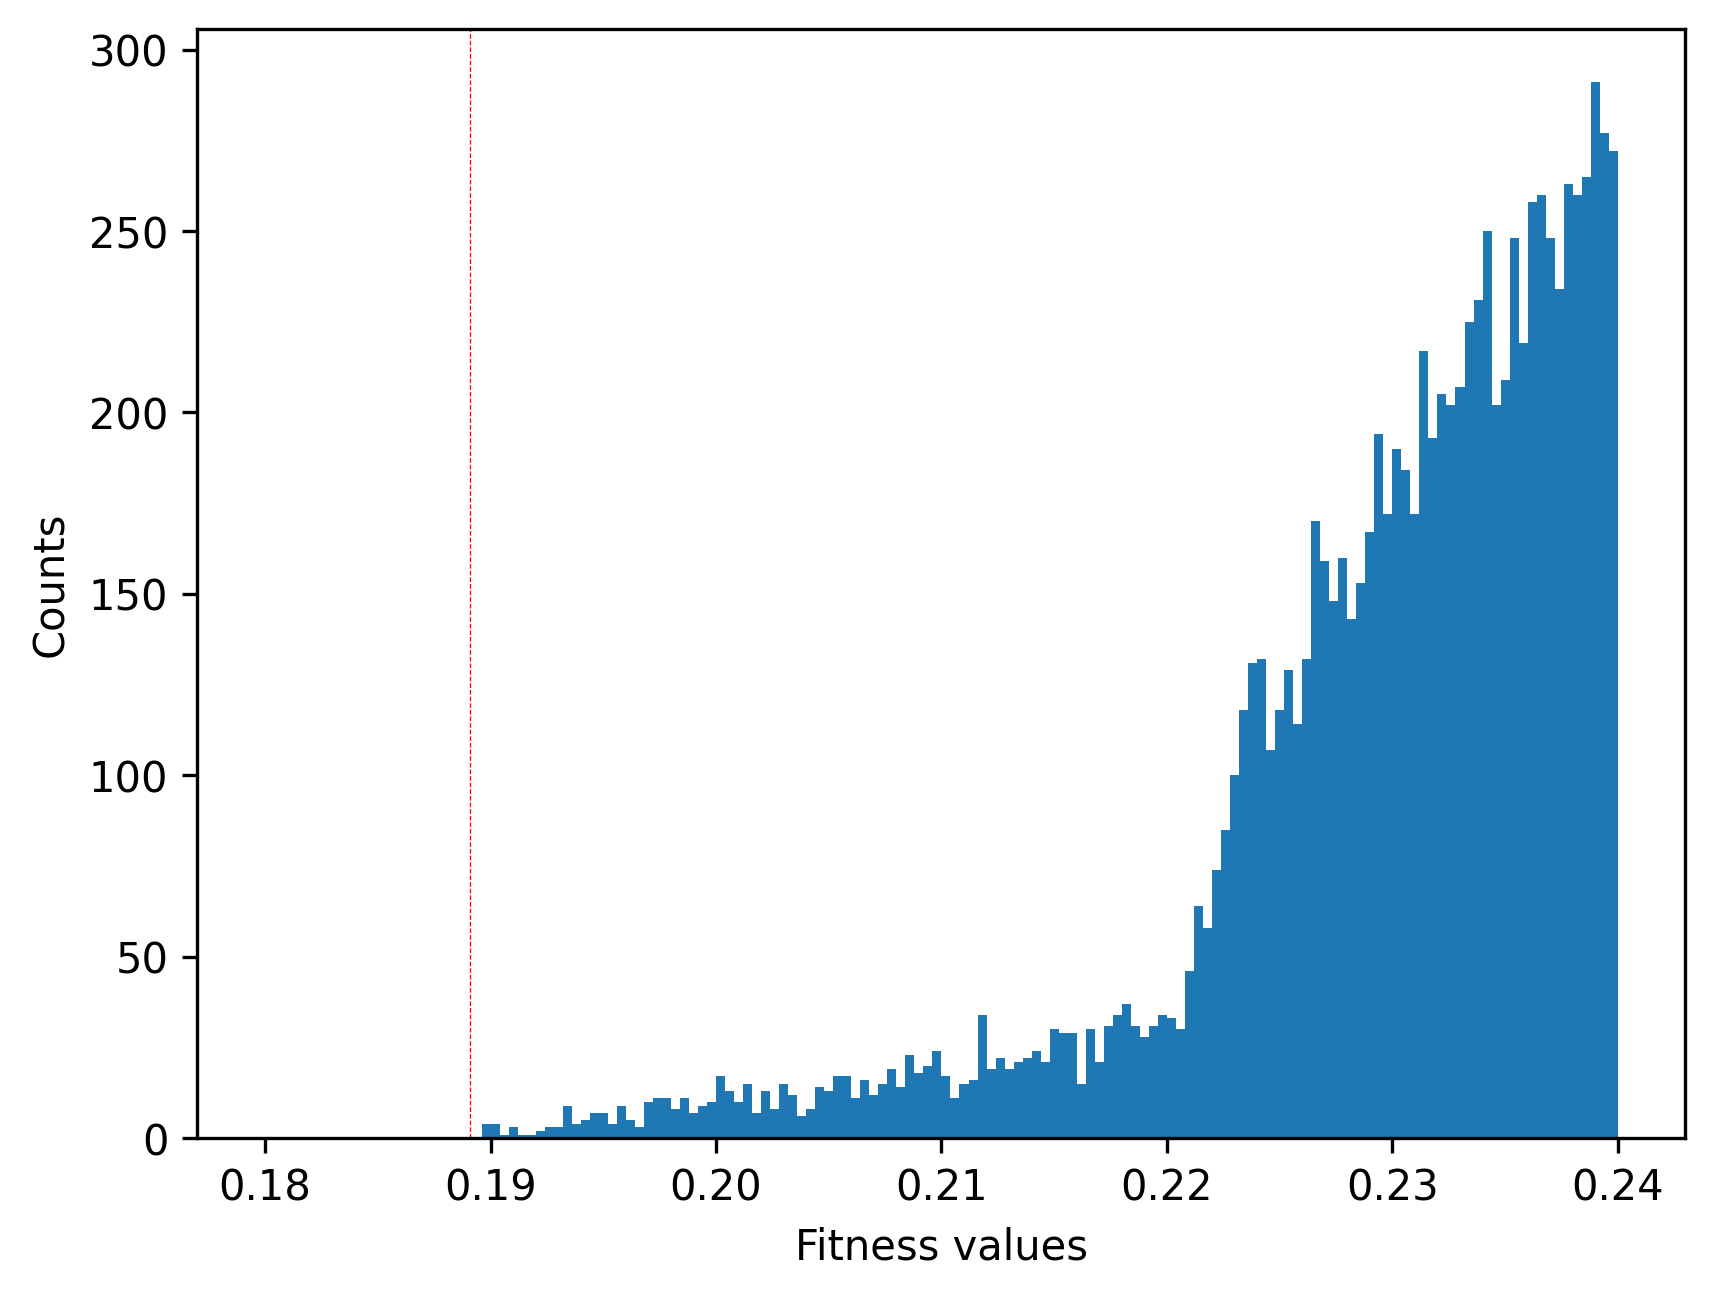

In [34]:
plt.hist(fitness_values_rules, range=[0.18, 0.24], bins=150)
plt.xlabel("Fitness values")
plt.ylabel("Counts")
plt.axvline(lemoo._generation_history[-1].fitness_fun_values[0], c="red", linestyle="dashed", linewidth=0.3)